In [1]:
# In this file I will visualize the dataset & implement the CNN model for classification

README.md:   0%|          | 0.00/518 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/150M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/251 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/66 [00:00<?, ? examples/s]

| Class           |   Count | Percentage   |
|:----------------|--------:|:-------------|
| Covid           |     111 | 44.2%        |
| Normal          |      70 | 27.9%        |
| Viral Pneumonia |      70 | 27.9%        |


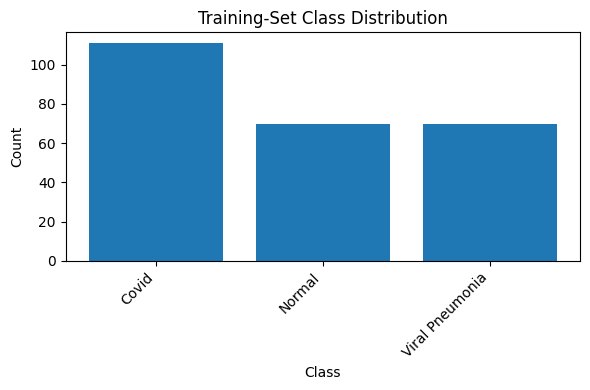

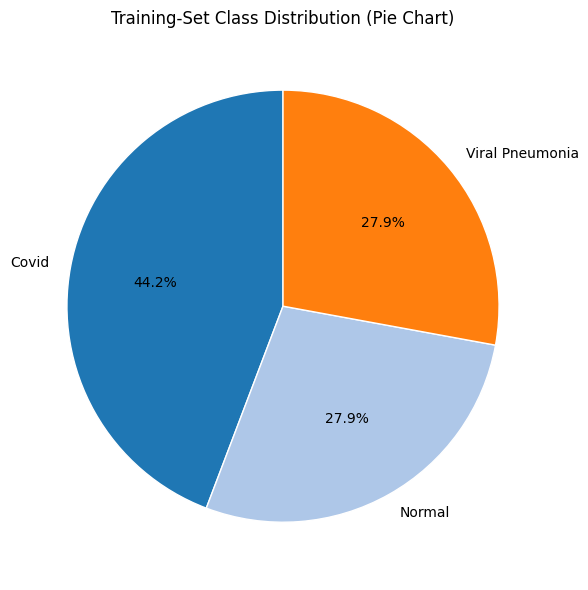

In [2]:
!pip install -q torch torchvision datasets pillow scikit-learn matplotlib pandas tabulate tensorflow seaborn
import warnings
warnings.filterwarnings("ignore")

# 1. define the dataset
from datasets import load_dataset
ds = load_dataset("yuighj123/covid-19-classification")
train = ds["train"]

# 2. Count labels to see the imbalance 
from collections import Counter
labels = train["label"]
names  = train.features["label"].names
cnts   = Counter(labels)
total  = len(labels)

# 3. display a summary table
import pandas as pd
summary = []
for idx, name in enumerate(names):
    c = cnts.get(idx, 0)
    summary.append({
        "Class":      name,
        "Count":      c,
        "Percentage": f"{(c/total)*100:.1f}%"
    })
df = pd.DataFrame(summary)
print(df.to_markdown(index=False))

# 4. Plot the imbalance classes
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(df["Class"], df["Count"])
plt.title("Training-Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

cmap   = plt.get_cmap("tab20")
colors = cmap.colors[: len(df)]

#  Plot the pie chart
plt.figure(figsize=(6,6))
plt.pie(
    df["Count"],
    labels=df["Class"],
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)
plt.title("Training-Set Class Distribution (Pie Chart)")
plt.axis("equal") 
plt.tight_layout()
plt.show()

In [3]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check dataset structure and number of classes
print("Dataset features:", ds['train'].features)
num_classes = len(set(ds['train']['label']))
print(f"Number of classes: {num_classes}")

# Preprocess images: handle various input formats, resize to 224x224, convert to RGB
def preprocess_image(example, target_size=(224, 224)):
    image = example['image'] 
    try:
        # Handle different image formats
        if isinstance(image, Image.Image):
            pass 
        elif isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype(np.uint8))
        elif isinstance(image, list):
            # Convert list to NumPy array
            image = np.array(image, dtype=np.float32)
            if image.ndim == 1:  
                image = image.reshape((4248, 3480)) 
            elif image.ndim == 3 and image.shape[-1] not in [1, 3]:
                raise ValueError(f"Unexpected image shape: {image.shape}")
            image = Image.fromarray(image.astype(np.uint8))
        elif isinstance(image, bytes):
            from io import BytesIO
            image = Image.open(BytesIO(image))
        else:
            raise ValueError(f"Unsupported image type: {type(image)}")
        
        # Ensure RGB and resize
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = image.resize(target_size)
        # Convert to NumPy array and normalize
        image = np.array(image, dtype=np.float32) / 255.0
        example['image'] = image
        return example
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Apply preprocessing 
ds = ds.map(preprocess_image, batched=False, fn_kwargs={'target_size': (224, 224)})

# Filter out failed preprocessing
ds = ds.filter(lambda x: x['image'] is not None)

# Convert dataset to NumPy arrays for training
train_images = np.array([example['image'] for example in ds['train']], dtype=np.float32)
train_labels = np.array([example['label'] for example in ds['train']], dtype=np.int32)

# Handle validation split
if 'test' in ds:
    val_images = np.array([example['image'] for example in ds['test']], dtype=np.float32)
    val_labels = np.array([example['label'] for example in ds['test']], dtype=np.int32)
else:
    from sklearn.model_selection import train_test_split
    train_images, val_images, train_labels, val_labels = train_test_split(
        train_images, train_labels, test_size=0.2, random_state=42
    )

train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  

# Create data generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

# the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

val_predictions = model.predict(val_images)
val_pred_labels = np.argmax(val_predictions, axis=1)

print("\nClassification Report:")
print(classification_report(val_labels, val_pred_labels))

# Confusion matrix
cm = confusion_matrix(val_labels, val_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.close()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_history.png')
plt.close()


2025-05-24 16:07:14.451719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 16:07:14.498222: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748095634.549412     139 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748095634.565849     139 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748095634.611992     139 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Dataset features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Covid', 'Normal', 'Viral Pneumonia'], id=None)}
Number of classes: 3


Map:   0%|          | 0/251 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Filter:   0%|          | 0/251 [00:00<?, ? examples/s]

Filter:   0%|          | 0/66 [00:00<?, ? examples/s]

2025-05-24 16:18:38.948430: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2706 - loss: 2.4258 - val_accuracy: 0.5455 - val_loss: 1.0323
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4910 - loss: 1.0361 - val_accuracy: 0.6818 - val_loss: 0.7403
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7630 - loss: 0.6137 - val_accuracy: 0.8636 - val_loss: 0.4077
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7354 - loss: 0.4931 - val_accuracy: 0.8485 - val_loss: 0.3085
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8535 - loss: 0.4217 - val_accuracy: 0.7576 - val_loss: 0.5207
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8892 - loss: 0.4039 - val_accuracy: 0.7424 - val_loss: 0.5750
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8799 - loss: 0.2971 - val_accuracy: 0.8030 - val_loss: 0.3118
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8731 - loss: 0.2782 - val_accuracy: 0.7727 - val_loss: 0.3583
Epoch 9/